### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Input
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [3]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



In [4]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [5]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [6]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [7]:

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MAX_VOCAB_SIZE = 8000

# Tokenizador para inputs
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario de entrada:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

# Tokenizador para outputs
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario de salida:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

# Limitar longitudes para cuidar RAM
max_input_len = 16
max_out_len = 18

# Padding
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')

# One-hot encoding de la salida
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)

print("encoder_input_sequences shape:", encoder_input_sequences.shape)
print("decoder_input_sequences shape:", decoder_input_sequences.shape)
print("decoder_targets shape:", decoder_targets.shape)

Palabras en el vocabulario de entrada: 1799
Sentencia de entrada más larga: 9
Palabras en el vocabulario de salida: 1806
Sentencia de salida más larga: 10
encoder_input_sequences shape: (6033, 16)
decoder_input_sequences shape: (6033, 18)
decoder_targets shape: (6033, 18, 1807)


### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [ ]:
# Instalar gensim
#!pip install gensim

# Carga el modelo FastText preentrenado
import gensim.downloader as api
import numpy as np

print("Cargando modelo FastTex")
fasttext_model = api.load('fasttext-wiki-news-subwords-300')
print("Modelo cargado.")

# Armado de embedding_matrix con los vectores de FastText
EMBEDDING_DIM = 300  #300 dimensiones
vocab_size = min(MAX_VOCAB_SIZE, len(word2idx_inputs) + 1)

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, idx in word2idx_inputs.items():
    if idx < MAX_VOCAB_SIZE:
        if word in fasttext_model:
            embedding_matrix[idx] = fasttext_model[word]

Cargando modelo FastText... (puede tardar unos minutos)
[==================================================] 100.0% 958.5/958.4MB downloaded
Modelo cargado.


### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

##### Encoder

In [19]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_matrix):
        super().__init__()
        self.lstm_size = 256
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1]

        self.embedding = nn.Embedding(vocab_size, self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False

        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            batch_first=True
        )

    def forward(self, x):
        x = self.embedding(x)
        outputs, (h, c) = self.lstm(x)
        return (h, c)

##### Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.lstm_size = 256
        self.num_layers = 1
        self.embedding_dim = 256  

        self.embedding = nn.Embedding(vocab_size, self.embedding_dim, padding_idx=0)

        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            batch_first=True
        )

        self.fc = nn.Linear(self.lstm_size, vocab_size)

    def forward(self, x, prev_state):
        x = self.embedding(x)
        output, (h, c) = self.lstm(x, prev_state)
        output = self.fc(output[:, -1, :])  
        return output, (h, c)

##### Modelo Seq2Seq

In [21]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, encoder_input, decoder_input, teacher_forcing_ratio=0.5):
        batch_size = decoder_input.shape[0]
        target_len = decoder_input.shape[1]
        vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, target_len, vocab_size).to(encoder_input.device)

        state = self.encoder(encoder_input)
        input = decoder_input[:, 0].unsqueeze(1)

        for t in range(target_len):
            output, state = self.decoder(input, state)
            outputs[:, t, :] = output

            top1 = output.argmax(1).unsqueeze(1)
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            input = decoder_input[:, t].unsqueeze(1) if teacher_force else top1

        return outputs


##### Dataset y Dataloaders

In [22]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# split 80/20
X_train_enc, X_val_enc, X_train_dec_in, X_val_dec_in, X_train_dec_out, X_val_dec_out = train_test_split(
    encoder_input_sequences, decoder_input_sequences, decoder_output_sequences,
    test_size=0.2, random_state=42
)

class ChatDataset(Dataset):
    def __init__(self, enc, dec_in, dec_out):
        self.enc = enc
        self.dec_in = dec_in
        self.dec_out = dec_out

    def __len__(self):
        return len(self.enc)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.enc[idx], dtype=torch.long),
            torch.tensor(self.dec_in[idx], dtype=torch.long),
            torch.tensor(self.dec_out[idx], dtype=torch.long)
        )

train_loader = DataLoader(ChatDataset(X_train_enc, X_train_dec_in, X_train_dec_out), batch_size=64, shuffle=True)
valid_loader = DataLoader(ChatDataset(X_val_enc, X_val_dec_in, X_val_dec_out), batch_size=64)

##### Entrenamiento

In [ ]:
def train(model, train_loader, valid_loader, optimizer, criterion, epochs=10, teacher_forcing_ratio=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch in train_loader:
            encoder_input, decoder_input, decoder_output = [x.to(device) for x in batch]
            optimizer.zero_grad()

            output = model(encoder_input, decoder_input, teacher_forcing_ratio)
            loss = criterion(output.view(-1, output.shape[-1]), decoder_output.view(-1))

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in valid_loader:
                encoder_input, decoder_input, decoder_output = [x.to(device) for x in batch]
                output = model(encoder_input, decoder_input, 0) 
                loss = criterion(output.view(-1, output.shape[-1]), decoder_output.view(-1))
                val_loss += loss.item()

        avg_val_loss = val_loss / len(valid_loader)
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    return history


##### Instanciado y entrenamiento

In [35]:
encoder = Encoder(vocab_size=vocab_size, embedding_matrix=embedding_matrix)
decoder = Decoder(vocab_size=num_words_output)
model = Seq2Seq(encoder, decoder)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

history1 = train(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=20,
    teacher_forcing_ratio=0.5
)

Epoch 1/20 | Train Loss: 4.6134 | Val Loss: 4.2351
Epoch 2/20 | Train Loss: 3.8091 | Val Loss: 4.3962
Epoch 3/20 | Train Loss: 3.7003 | Val Loss: 4.3445
Epoch 4/20 | Train Loss: 3.5673 | Val Loss: 4.1981
Epoch 5/20 | Train Loss: 3.4872 | Val Loss: 4.1115
Epoch 6/20 | Train Loss: 3.3772 | Val Loss: 4.1365
Epoch 7/20 | Train Loss: 3.3694 | Val Loss: 4.0367
Epoch 8/20 | Train Loss: 3.2859 | Val Loss: 4.0538
Epoch 9/20 | Train Loss: 3.2358 | Val Loss: 4.0446
Epoch 10/20 | Train Loss: 3.1748 | Val Loss: 4.0463
Epoch 11/20 | Train Loss: 3.1287 | Val Loss: 4.0096
Epoch 12/20 | Train Loss: 3.0628 | Val Loss: 4.0426
Epoch 13/20 | Train Loss: 3.0905 | Val Loss: 4.0444
Epoch 14/20 | Train Loss: 2.9998 | Val Loss: 4.0291
Epoch 15/20 | Train Loss: 2.9853 | Val Loss: 4.0299
Epoch 16/20 | Train Loss: 2.9338 | Val Loss: 4.0636
Epoch 17/20 | Train Loss: 2.9146 | Val Loss: 4.0333
Epoch 18/20 | Train Loss: 2.8867 | Val Loss: 4.0765
Epoch 19/20 | Train Loss: 2.7963 | Val Loss: 4.0547
Epoch 20/20 | Train L

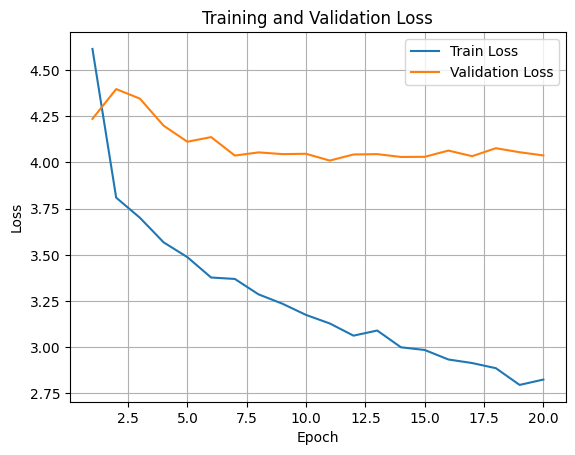

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(history1['train_loss']) + 1)

sns.lineplot(x=epoch_count, y=history1['train_loss'], label='Train Loss')
sns.lineplot(x=epoch_count, y=history1['val_loss'], label='Validation Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [ ]:
def generar_respuesta(input_text, input_tokenizer, output_tokenizer, model, max_len=18):
    model.eval()
    device = next(model.parameters()).device

    # Tokenizar la entrada y convertir a tensor
    seq = input_tokenizer.texts_to_sequences([input_text])
    seq = torch.tensor(pad_sequences(seq, maxlen=max_input_len), dtype=torch.long).to(device)

    # Codificar input
    with torch.no_grad():
        state = model.encoder(seq)

    # Arrancamos con el token <sos>
    sos_token = output_tokenizer.word_index['<sos>']
    eos_token = output_tokenizer.word_index['<eos>']
    input_token = torch.tensor([[sos_token]], dtype=torch.long).to(device)

    output_tokens = []

    for _ in range(max_len):
        with torch.no_grad():
            output, state = model.decoder(input_token, state)
            top1 = output.argmax(1).item()

        if top1 == eos_token:
            break

        output_tokens.append(top1)
        input_token = torch.tensor([[top1]], dtype=torch.long).to(device)

    # Convertir indices a palabras
    idx2word = {i: w for w, i in output_tokenizer.word_index.items()}
    respuesta = ' '.join([idx2word.get(idx, '<unk>') for idx in output_tokens])
    return respuesta

In [29]:
pregunta = "How are you?"
respuesta = generar_respuesta(pregunta, input_tokenizer, output_tokenizer, model)
print("Bot:", respuesta)

Bot: i am fine


In [33]:
pregunta = "Who are you?"
respuesta = generar_respuesta(pregunta, input_tokenizer, output_tokenizer, model)
print("Bot:", respuesta)

Bot: i am


In [49]:
pregunta = "hello"
respuesta = generar_respuesta(pregunta, input_tokenizer, output_tokenizer, model)
print("Bot:", respuesta)

Bot: hello how are


In [50]:
pregunta = "My name is Lucas"
respuesta = generar_respuesta(pregunta, input_tokenizer, output_tokenizer, model)
print("Bot:", respuesta)

Bot: what do you do for a living


In [56]:
pregunta = "Thank you"
respuesta = generar_respuesta(pregunta, input_tokenizer, output_tokenizer, model)
print("Bot:", respuesta)

Bot: what do you
